# NYPD Civilian Complaints
This project contains data on 12,000 civilian complaints filed against New York City police officers. Interesting questions to consider include:
- Does the length that the complaint is open depend on ethnicity/age/gender?
- Are white-officer vs non-white complaintant cases more likely to go against the complainant? 
- Are allegations more severe for cases in which the officer and complaintant are not the same ethnicity?
- Are the complaints of women more succesful than men (for the same allegations?)

There are a lot of questions that can be asked from this data, so be creative! You are not limited to the sample questions above.

### Getting the Data
The data and its corresponding data dictionary is downloadable [here](https://www.propublica.org/datastore/dataset/civilian-complaints-against-new-york-city-police-officers). The data dictionary is in the project03 folder.

Note: you don't need to provide any information to obtain the data. Just agree to the terms of use and click "submit."

### Cleaning and EDA
- Clean the data.
    - Certain fields have "missing" data that isn't labeled as missing. For example, there are fields with the value "Unknown." Do some exploration to find those values and convert them to null values.
    - You may also want to combine the date columns to create a `datetime` column for time-series exploration.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

### Assessment of Missingness
- Assess the missingness per the requirements in `project03.ipynb`

### Hypothesis Test / Permutation Test
Find a hypothesis test or permutation test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
TODO

### Cleaning and EDA
TODO

### Assessment of Missingness
TODO

### Hypothesis Test
TODO

# Code

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

In [4]:
nypd = pd.read_csv('allegations_202007271729.csv')

df = nypd.copy()

df['complainant_ethnicity'] = df ['complainant_ethnicity'].replace('Unknown', np.NaN)
df['complainant_gender'] = df['complainant_gender'].replace('Not described', np.NaN)
df['contact_reason'] = df['contact_reason'].replace('No contact', np.NaN)
df['complainant_age_incident'] = df['complainant_age_incident'].apply(lambda x: np.NaN if x < 0 else x)

preclean = df.assign(date_received=(df['month_received'].astype(str) + ' ' + \
                                    df['year_received'].astype(str)).apply(pd.to_datetime))
cleaned = preclean.assign(date_closed=(df['month_closed'].astype(str) + ' ' + \
                                       df['year_closed'].astype(str)).apply(pd.to_datetime))

In [7]:
useful_cols = ['complainant_ethnicity',
            'complainant_gender',
            'complainant_age_incident',
            'allegation',
            'contact_reason',
            'outcome_description',
            'board_disposition',
            'date_received',
            'date_closed',
            ]
only_binary = cleaned[(cleaned['complainant_gender'] == 'Male') | (cleaned['complainant_gender'] == 'Female')]
q_data = only_binary.loc[:, useful_cols]
q_data['success'] = only_binary['board_disposition'].apply(lambda x: 0 if x in ['Unsubstantiated', 'Exonerated'] else 1)
q_data['duration'] = q_data['date_closed'] - q_data['date_received']
q_data = q_data.reset_index(drop=True)
q_data

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

In [176]:
# perm test: is missingness in 'complainant_ethnicity' dependent on 'success'
# reject, there is indeed dependency

n_repetitions = 500

tvds = []
for _ in range(n_repetitions):

    # shuffle the success column
    shuffled_col = (
        q_data['success']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )

    # put them in a table
    shuffled = (
        q_data
        .assign(**{
            'success': shuffled_col,
            'is_null': q_data['complainant_ethnicity'].isnull()
        })
    )

    # compute the tvd
    shuffled = (
        shuffled
        .pivot_table(index='is_null', columns='success', aggfunc='size')
        .apply(lambda x:x / x.sum(), axis=1)
    )

    tvd = shuffled.diff().iloc[-1].abs().sum() / 2
    # add it to the list of results

    tvds.append(tvd)

distr = (
    q_data
    .assign(is_null=q_data.complainant_ethnicity.isnull())
    .pivot_table(index='is_null', columns='success', aggfunc='size')
    .apply(lambda x:x / x.sum(), axis=1)
)
obs = distr.diff().iloc[-1].abs().sum() / 2
pval = np.mean(tvds > obs)
pval

0.016

In [186]:
n_repetitions = 500
race = q_data[q_data['allegation'] == 'Race'].reset_index(drop=True)
tvds = []
for _ in range(n_repetitions):

    # shuffle the success column
    shuffled_col = (
        race['success']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )

    # put them in a table
    shuffled = (
        race
        .assign(**{
            'success': shuffled_col,
            'is_null': race['complainant_ethnicity'].isnull()
        })
    )

    # compute the tvd
    shuffled = (
        shuffled
        .pivot_table(index='is_null', columns='success', aggfunc='size')
        .apply(lambda x:x / x.sum(), axis=1)
    )

    tvd = shuffled.diff().iloc[-1].abs().sum() / 2
    # add it to the list of results

    tvds.append(tvd)

distr = (
    race
    .assign(is_null=race.complainant_ethnicity.isnull())
    .pivot_table(index='is_null', columns='success', aggfunc='size')
    .apply(lambda x:x / x.sum(), axis=1)
)
obs = distr.diff().iloc[-1].abs().sum() / 2
pval = np.mean(tvds > obs)
pval

0.014

In [162]:
# perm test: is missingness of 'complainant_ethnicity' dependent on 'complainant_gender'?
# don't reject, there is no dependency

n_repetitions = 500

tvds = []
for _ in range(n_repetitions):

    # shuffle the success column
    shuffled_col = (
        q_data['complainant_gender']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )

    # put them in a table
    shuffled = (
        q_data
        .assign(**{
            'complainant_gender': shuffled_col,
            'is_null': q_data['complainant_ethnicity'].isnull()
        })
    )

    # compute the tvd
    shuffled = (
        shuffled
        .pivot_table(index='is_null', columns='complainant_gender', aggfunc='size')
        .apply(lambda x:x / x.sum(), axis=1)
    )

    tvd = shuffled.diff().iloc[-1].abs().sum() / 2
    # add it to the list of results

    tvds.append(tvd)

distr = (
    q_data
    .assign(is_null=q_data.complainant_ethnicity.isnull())
    .pivot_table(index='is_null', columns='complainant_gender', aggfunc='size')
    .apply(lambda x:x / x.sum(), axis=1)
)
obs = distr.diff().iloc[-1].abs().sum() / 2
pval = np.mean(tvds > obs)
pval

0.314

In [440]:
# permutation test: are women more likely to win their cases than males?

n_repetitions = 1000

alleg = ['Physical force', 'Word', 'Refusal to provide name/shield number', 'Threat of arrest']

diffs = [[], [], [], []]

for i in range(len(alleg)):
    filt = q_data[q_data['allegation'] == alleg[i]].reset_index(drop=True)
        
    for _ in range(n_repetitions):
        # shuffle the successes
        
        shuffled_successes = (
            filt['success']
            .sample(replace=False, frac=1)
            .reset_index(drop=True)
        )

        # put them in a table
        shuffled = (
            filt
            .assign(**{'shuffled success': shuffled_successes})
        )

        # compute the group differences (test statistic!)
        group_means = (
            shuffled
            .groupby('complainant_gender')
            .mean()
            .loc[:, 'shuffled success']
        )
        difference = group_means.diff().iloc[-1]
        
        # add it to the list of results
        diffs[i].append(abs(difference))

lst=[]
for i in range(len(diffs)):
    diff_series = pd.Series(diffs[i])
    pval = (diff_series >=  obs_diff[i]).mean()
    lst.append(pval)
    
lst

[0.001, 0.046, 0.035, 0.016]

In [443]:
n_repetitions = 1000

alleg = ['Physical force', 'Word', 'Vehicle stop', 'Threat of force (verbal or physical)']

diffs = [[], [], [], []]

# we're doing 1000 repetitions (on each allegation) to ensure accuracy

for i in range(len(alleg)):
    
    # narrowing the dataframe down to the rows with the current allegation
    filt = q_data[q_data['allegation'] == alleg[i]].reset_index(drop=True)
        
    for _ in range(n_repetitions):
        # shuffle the successes
        
        shuffled_successes = (
            filt['success']
            .sample(replace=False, frac=1)
            .reset_index(drop=True)
        )

        # put them in a table
        shuffled = (
            filt
            .assign(**{'shuffled success': shuffled_successes})
        )

        # compute the group differences (test statistic!)
        group_means = (
            shuffled
            .groupby('complainant_gender')
            .mean()
            .loc[:, 'shuffled success']
        )
        difference = group_means.diff().iloc[-1]
        
        # add it to the list of results
        diffs[i].append(abs(difference))

# for each allegation in the series of differences, we perform the pval comparison with the corresponding
# observed difference in the obs_diff series

final_pvals = []
for i in range(len(diffs)):
    diff_series = pd.Series(diffs[i])
    pval = (diff_series >=  obs_diff[i]).mean()
    final_pvals.append(pval)
    
final_pvals

[0.001, 0.04, 0.116, 0.882]

In [442]:
alleg = ['Physical force', 'Word', 'Vehicle stop', 'Threat of force (verbal or physical)']

obs_diff = []
for i in alleg:
    filt = q_data[q_data['allegation'] == i].reset_index(drop=True)
    observed_difference = (
        filt
        .groupby('complainant_gender')['success']
        .mean()
        .diff()
        .iloc[-1]
    )
    obs_diff.append(observed_difference)
    
obs_diff = pd.Series(obs_diff)
obs_diff

0    0.036245
1    0.030937
2    0.060682
3    0.009670
dtype: float64

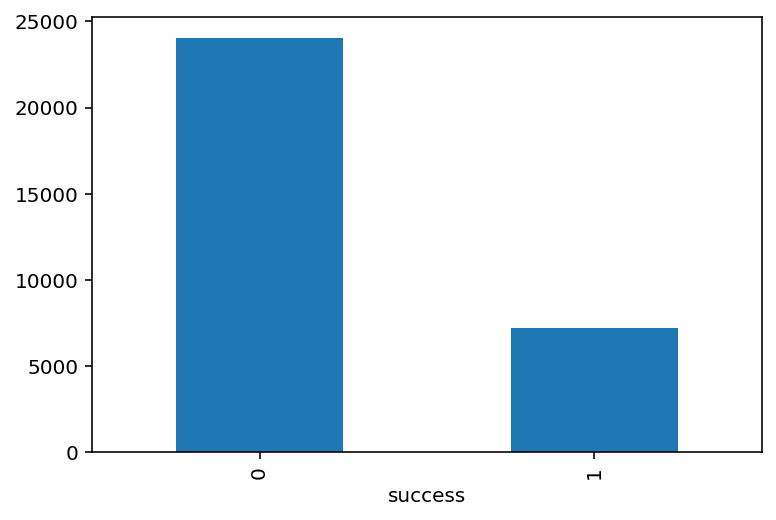

In [313]:
# univariate analyses

# From just looking at the complainant_gender column, we can see that an overwhelming majority of complaints are filed
# by men.
q_data['complainant_gender'].value_counts().plot(kind='bar')

# From the success column, we can see that only around 25% of cases are won against the police. Any substantiated
# value in 'board_disposition' constitutes a win for the complainant.
q_data.pivot_table(index='success', aggfunc='size').plot(kind='bar')

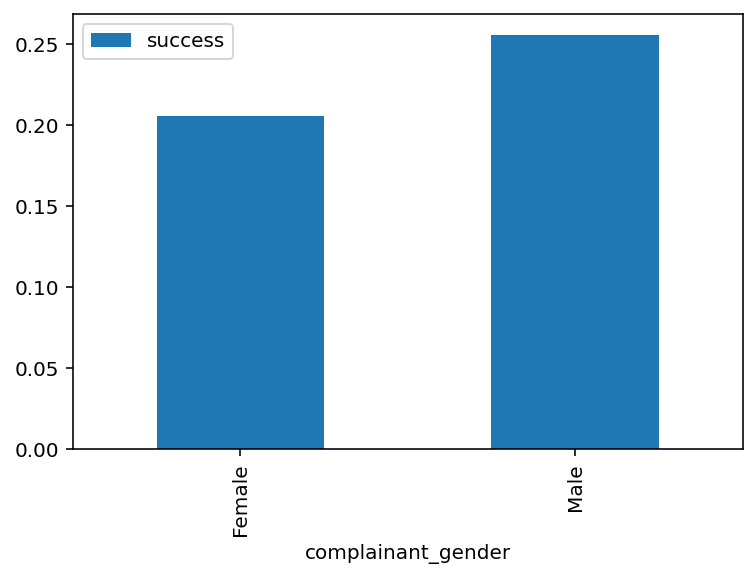

In [395]:
# bivariate analyses

# Men seem to have a higher win rate for cases than women.
q_data.pivot_table(index='complainant_gender', values=['success'], aggfunc='mean').plot(kind='bar')

### Assessment of Missingness

### Hypothesis Test

In [438]:
q_data['allegation'].value_counts().head(15)

Physical force                           4782
Word                                     3842
Stop                                     2259
Search (of person)                       2007
Frisk                                    1863
Refusal to provide name/shield number    1470
Vehicle search                           1395
Threat of arrest                         1332
Vehicle stop                             1087
Threat of force (verbal or physical)      887
Question and/or stop                      679
Other                                     612
Gun Pointed                               558
Strip-searched                            547
Question                                  519
Name: allegation, dtype: int64

In [435]:
# proportion of females in the data set
fem_only= q_data.groupby('complainant_gender').size()
prop_fem = fem_only[0] / fem_only.sum()

# proportion of women who filed against the police for physical force
pf = q_data[q_data['allegation'] == 'Physical force'].groupby('complainant_gender').size()
prop_pf = pf[0] / pf.sum()

# proportion of women who filed against the police for word
w = q_data[q_data['allegation'] == 'Word'].groupby('complainant_gender').size()
prop_w = w[0] / w.sum()

# proportion of women who filed against the police for vehicle stop
vst = q_data[q_data['allegation'] == 'Vehicle stop'].groupby('complainant_gender').size()
prop_vst = vst[0] / vst.sum()

# proportion of women who filed against the police for threat of force
tof = q_data[q_data['allegation'] == 'Threat of force (verbal or physical)'].groupby('complainant_gender').size()
prop_tof = tof[0] / tof.sum()

alleg = ['Physical force', 'Word', 'Vehicle stop', 'Threat of force (verbal or physical)']

{'Whole population': prop_fem, 'Physical force': prop_pf, 'Word': prop_w, \
    'Vehicle stop': prop_vst, 'Threat of force (verbal or physical)': prop_tof}

{'Whole population': 0.1726675607826954,
 'Physical force': 0.1672940192388122,
 'Word': 0.2368558042686101,
 'Vehicle stop': 0.10487580496780129,
 'Threat of force (verbal or physical)': 0.12288613303269448}

In [ ]:
alleg = ['Physical force', 'Word', 'Vehicle stop', 'Threat of force (verbal or physical)']